In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re

# Ẩn cảnh báo để tránh làm rối output
warnings.filterwarnings("ignore")

print("Môi trường đã sẵn sàng!")


Môi trường đã sẵn sàng!


In [11]:
# Đọc file stop words
STOP_WORD_FILE = 'vietnamese-stopwords.txt'
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = set(file.read().split('\n'))  # Chuyển thành set để tìm kiếm nhanh hơn

# Thêm stop words bổ sung liên quan đến ngữ cảnh sản phẩm
additional_stop_words = {'hàng', 'sản', 'phẩm', 'mới', 'chất', 'việt', 'nam'}
stop_words.update(additional_stop_words)

In [12]:
# Đọc dữ liệu
df = pd.read_csv('Products_ThoiTrangNam_raw.csv')

In [13]:
# Kiểm tra tổng quan về dữ liệu
print(df.info())  # Thông tin về kiểu dữ liệu và giá trị thiếu
print(df.describe())  # Thống kê mô tả cho các cột số

# Kiểm tra các giá trị thiếu
print(df.isnull().sum())  # Tổng số giá trị thiếu trong mỗi cột

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49663 entries, 0 to 49662
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    49663 non-null  int64  
 1   product_name  49663 non-null  object 
 2   category      49663 non-null  object 
 3   sub_category  49663 non-null  object 
 4   link          49663 non-null  object 
 5   image         36443 non-null  object 
 6   price         49663 non-null  float64
 7   rating        49663 non-null  float64
 8   description   48700 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ MB
None
          product_id         price       rating
count   49663.000000  4.966300e+04  49663.00000
mean   117081.765419  2.336831e+05      3.08549
std     83785.218506  9.853191e+05      2.33958
min       100.000000  0.000000e+00      0.00000
25%     21905.500000  6.900000e+04      0.00000
50%    114906.000000  1.419000e+05      4.80000
75%    174075.50

# Dữ liệu có Cột image (13,220 giá trị thiếu) và Cột description (963 giá trị thiếu)

In [14]:
# Xử lý giá trị thiếu
df = df.dropna(subset=['image'])  # Xóa dòng thiếu 'image'
df['description'].fillna("Không có mô tả", inplace=True)

In [15]:
# Kiểm tra lại số lượng giá trị thiếu
print(df.isnull().sum())

product_id      0
product_name    0
category        0
sub_category    0
link            0
image           0
price           0
rating          0
description     0
dtype: int64


In [16]:
# Giảm kích thước dữ liệu: Chỉ giữ sản phẩm có rating >= 3.0
df = df[df['rating'] >= 3.0].reset_index(drop=True)
print(f"Số lượng sản phẩm sau khi lọc: {len(df)}")

Số lượng sản phẩm sau khi lọc: 21006


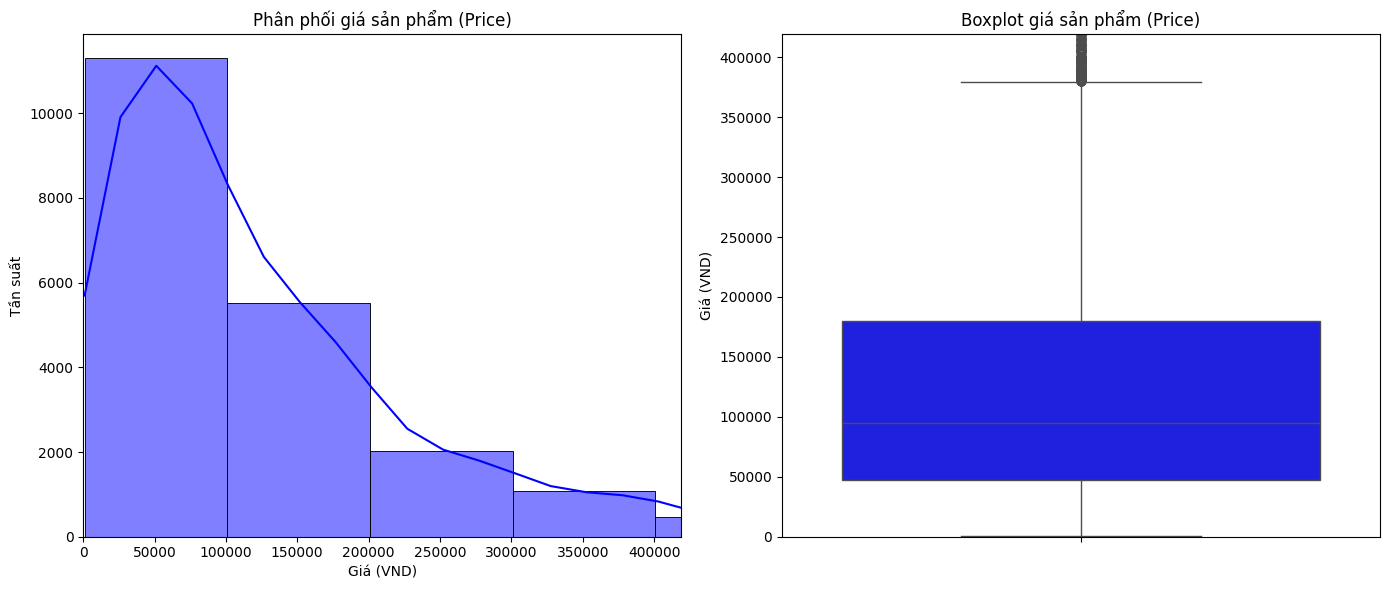

In [17]:
import seaborn as sns
# Phân phối của 'price'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True, color='blue', bins=50)
plt.title('Phân phối giá sản phẩm (Price)')
plt.xlabel('Giá (VND)')
plt.ylabel('Tần suất')
plt.xlim(0, df['price'].quantile(0.95))  # Giới hạn trục x để tránh outlier

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'], color='blue')
plt.title('Boxplot giá sản phẩm (Price)')
plt.ylabel('Giá (VND)')
plt.ylim(0, df['price'].quantile(0.95))  # Giới hạn để dễ quan sát
plt.tight_layout()
plt.show()

Histogram + KDE: Hiển thị phân phối giá, với giới hạn trục x để loại bỏ các giá trị outlier (dùng quantile 0.95).
Boxplot: Cho thấy các giá trị ngoại lai (outliers) và phân bố tổng quan của giá. Điều này giúp phát hiện các sản phẩm có giá bất thường (quá cao hoặc quá thấp).

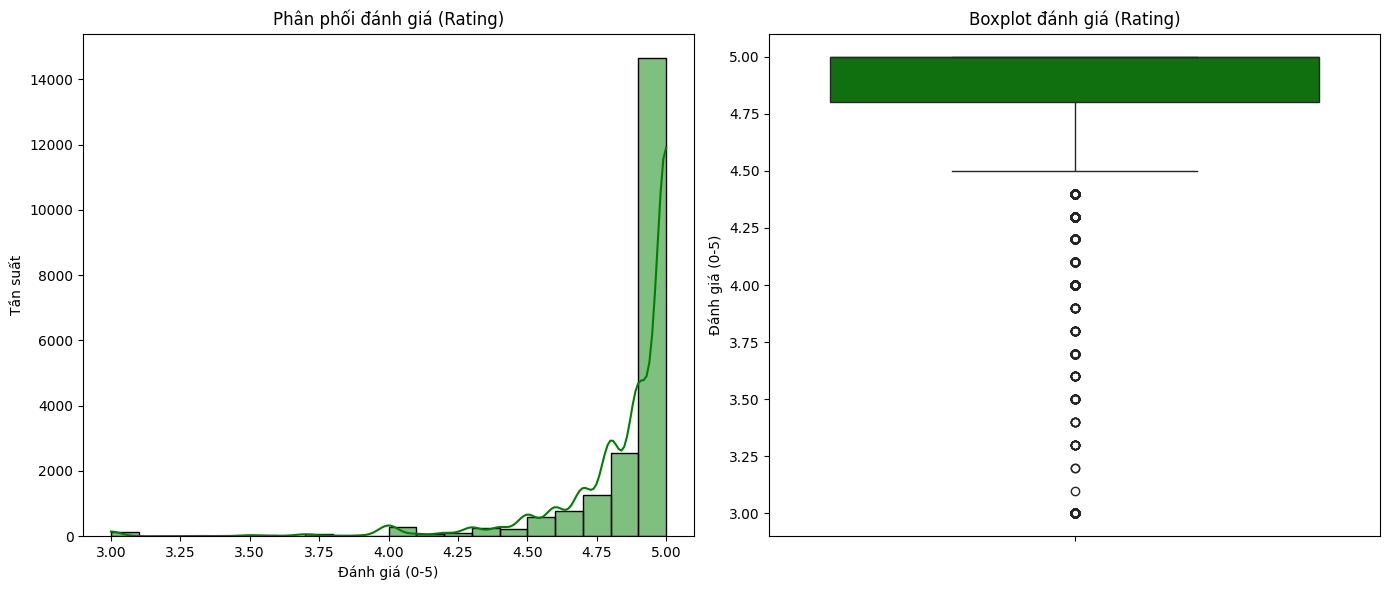

In [18]:
# Phân phối của 'rating'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['rating'], kde=True, color='green', bins=20)
plt.title('Phân phối đánh giá (Rating)')
plt.xlabel('Đánh giá (0-5)')
plt.ylabel('Tần suất')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['rating'], color='green')
plt.title('Boxplot đánh giá (Rating)')
plt.ylabel('Đánh giá (0-5)')
plt.tight_layout()
plt.show()

Histogram + KDE: Hiển thị phân phối đánh giá từ 0-5, cho thấy xu hướng đánh giá của người dùng.
Boxplot: Nhận diện các giá trị ngoại lai (nếu có) và mức độ tập trung của rating.

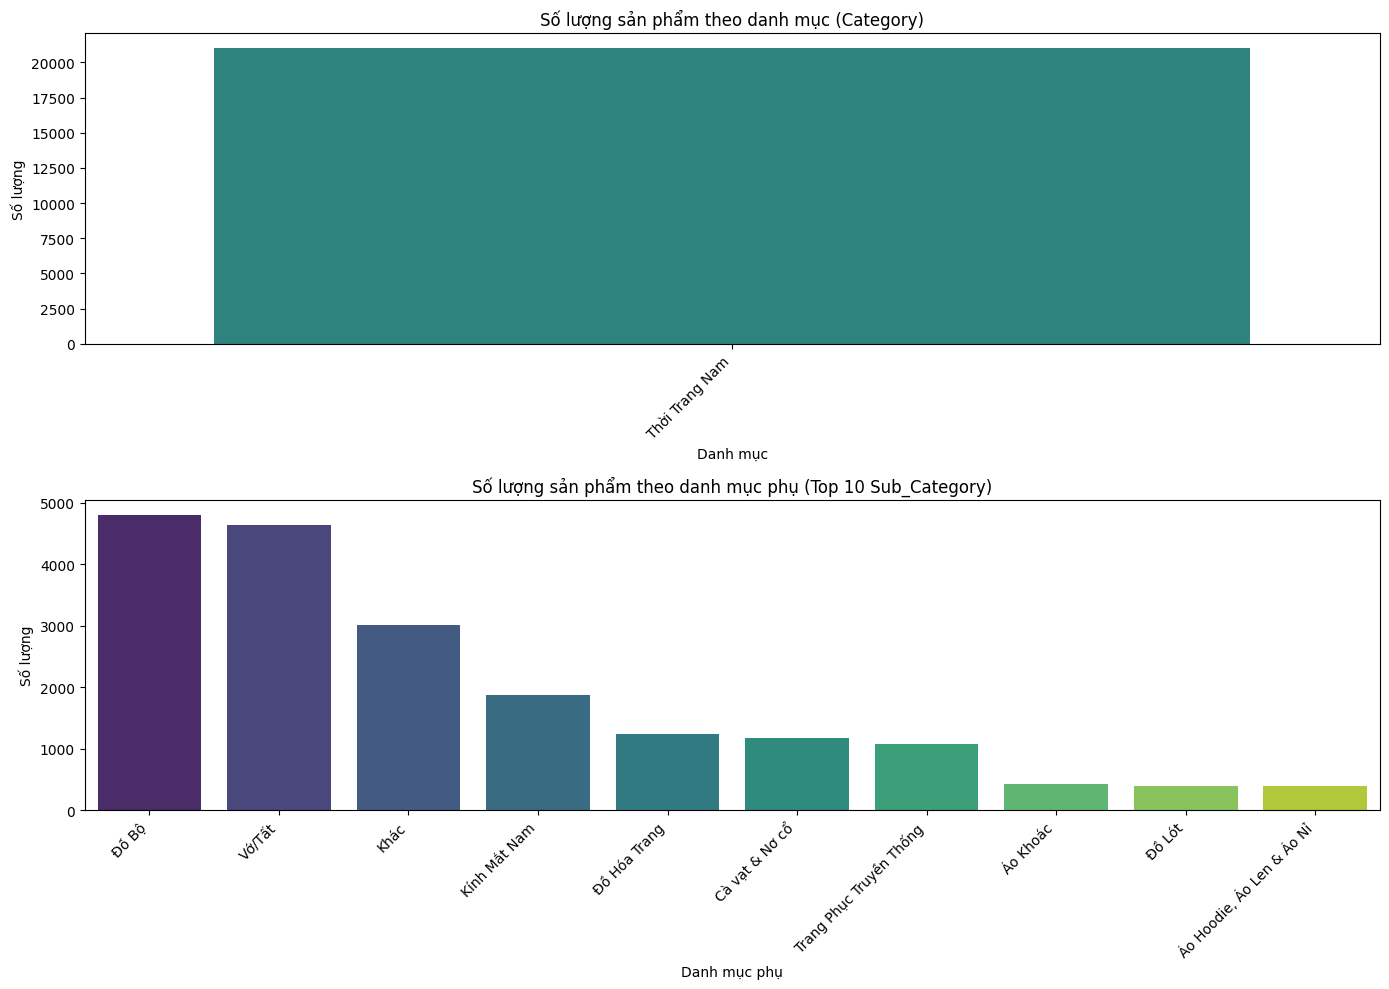

In [19]:
# Phân tích 'category' và 'sub_category'
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette='viridis')
plt.title('Số lượng sản phẩm theo danh mục (Category)')
plt.xlabel('Danh mục')
plt.ylabel('Số lượng')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
sns.countplot(data=df, x='sub_category', order=df['sub_category'].value_counts().index[:10], palette='viridis')  # Top 10 sub_category
plt.title('Số lượng sản phẩm theo danh mục phụ (Top 10 Sub_Category)')
plt.xlabel('Danh mục phụ')
plt.ylabel('Số lượng')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Countplot cho category: Đếm số lượng sản phẩm trong từng danh mục chính (ở đây đều là "Thời Trang Nam", nhưng nếu có thêm danh mục khác thì sẽ hữu ích).
Countplot cho sub_category (Top 10): Hiển thị các danh mục phụ phổ biến nhất, giúp hiểu loại sản phẩm nào chiếm ưu thế (ví dụ: Áo Ba Lỗ, Quần Jeans, v.v.).

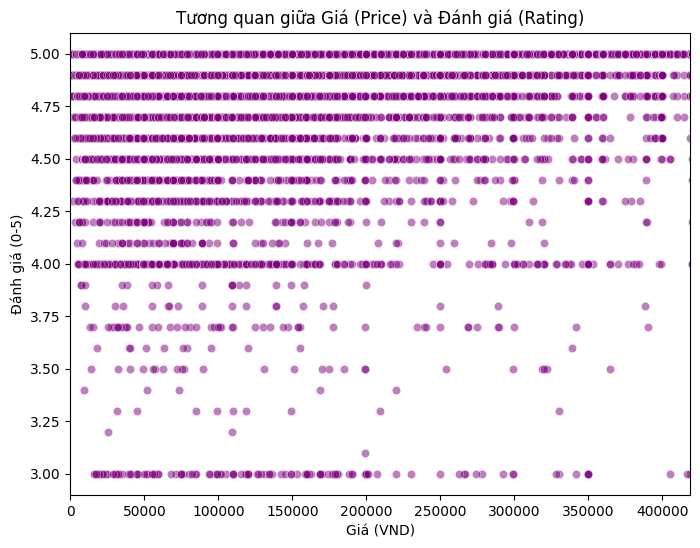


Hệ số tương quan Pearson giữa Price và Rating: 0.0287


In [20]:
# Tương quan giữa 'price' và 'rating'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='price', y='rating', alpha=0.5, color='purple')
plt.title('Tương quan giữa Giá (Price) và Đánh giá (Rating)')
plt.xlabel('Giá (VND)')
plt.ylabel('Đánh giá (0-5)')
plt.xlim(0, df['price'].quantile(0.95))  # Giới hạn để loại bỏ outlier
plt.show()

# Tính hệ số tương quan Pearson
correlation = df['price'].corr(df['rating'])
print(f"\nHệ số tương quan Pearson giữa Price và Rating: {correlation:.4f}")

Scatterplot: Trực quan hóa mối quan hệ giữa giá và đánh giá. Nếu các điểm phân bố ngẫu nhiên, có thể không có tương quan rõ ràng.
Hệ số Pearson: Đo lường mức độ tương quan tuyến tính giữa price và rating. Giá trị gần 0 cho thấy không có mối quan hệ tuyến tính mạnh.

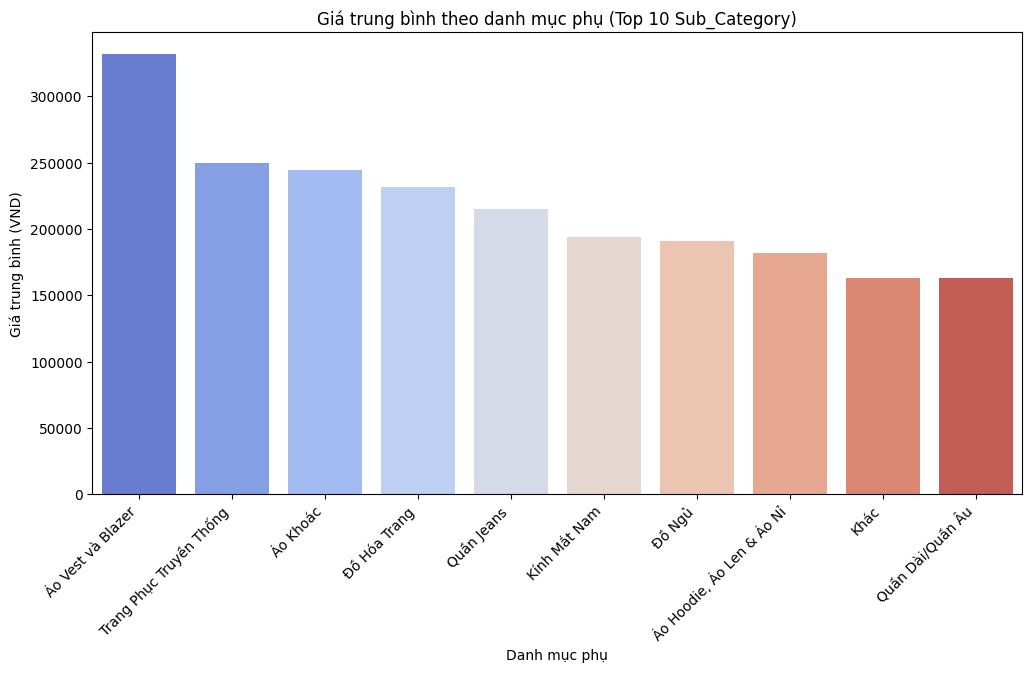

In [21]:
# Phân tích giá trung bình theo 'sub_category'
plt.figure(figsize=(12, 6))
price_by_subcat = df.groupby('sub_category')['price'].mean().sort_values(ascending=False)[:10]  # Top 10
sns.barplot(x=price_by_subcat.index, y=price_by_subcat.values, palette='coolwarm')
plt.title('Giá trung bình theo danh mục phụ (Top 10 Sub_Category)')
plt.xlabel('Danh mục phụ')
plt.ylabel('Giá trung bình (VND)')
plt.xticks(rotation=45, ha='right')
plt.show()

Barplot: Hiển thị top 10 danh mục phụ có giá trung bình cao nhất, giúp hiểu danh mục nào có giá trị cao (ví dụ: áo khoác, giày dép).

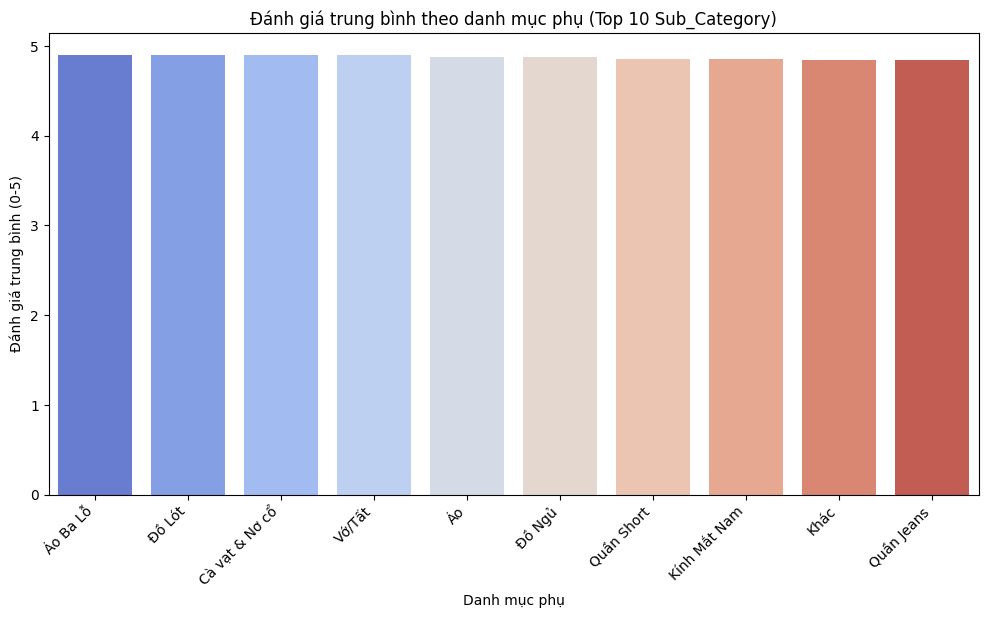

In [22]:
# Phân tích rating trung bình theo 'sub_category'
plt.figure(figsize=(12, 6))
rating_by_subcat = df.groupby('sub_category')['rating'].mean().sort_values(ascending=False)[:10]  # Top 10
sns.barplot(x=rating_by_subcat.index, y=rating_by_subcat.values, palette='coolwarm')
plt.title('Đánh giá trung bình theo danh mục phụ (Top 10 Sub_Category)')
plt.xlabel('Danh mục phụ')
plt.ylabel('Đánh giá trung bình (0-5)')
plt.xticks(rotation=45, ha='right')
plt.show()

Barplot: Hiển thị top 10 danh mục phụ có đánh giá trung bình cao nhất, cho thấy sản phẩm nào được người dùng yêu thích.

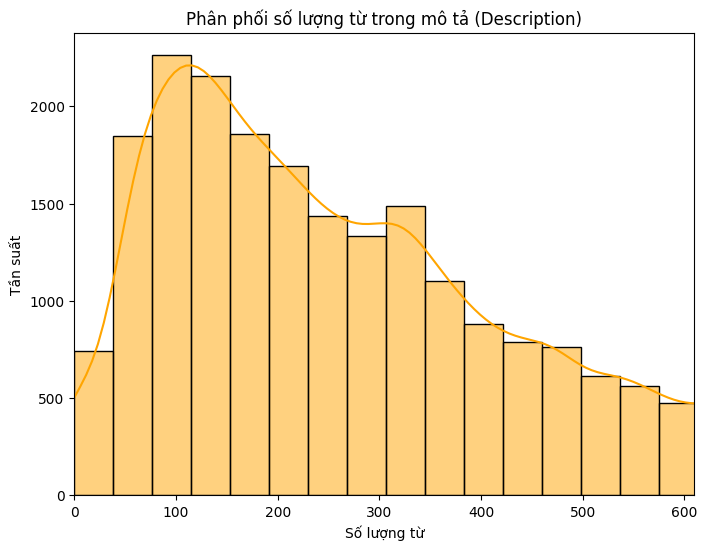

In [23]:
# Phân tích số lượng từ trong 'description'
df['description_word_count'] = df['description'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 6))
sns.histplot(df['description_word_count'], kde=True, color='orange', bins=30)
plt.title('Phân phối số lượng từ trong mô tả (Description)')
plt.xlabel('Số lượng từ')
plt.ylabel('Tần suất')
plt.xlim(0, df['description_word_count'].quantile(0.95))  # Giới hạn để tránh outlier
plt.show()

Histogram: Đếm số từ trong mô tả sản phẩm, giúp đánh giá mức độ chi tiết của thông tin sản phẩm. Nếu mô tả quá ngắn, có thể ảnh hưởng đến chất lượng gợi ý.

Trong các bài toán xử lý ngôn ngữ tự nhiên (NLP), dữ liệu đầu vào thường chưa được chuẩn hóa, chứa nhiều ký tự đặc biệt, số, hoặc từ không quan trọng. Vì vậy, tiền xử lý văn bản là bước quan trọng để làm sạch dữ liệu và cải thiện chất lượng mô hình. Trong phần này, chúng ta sẽ trình bày các bước tiền xử lý dữ liệu văn bản từ mô tả sản phẩm trên Shopee.

Hàm Kiểm Tra Từ Tiếng Việt "Sạch"

Để đảm bảo rằng chỉ các từ tiếng Việt hợp lệ được giữ lại, ta sử dụng hàm is_valid_vietnamese(word).

Hàm này sử dụng biểu thức chính quy để kiểm tra xem từ có chứa các ký tự tiếng Việt hợp lệ hay không

Hàm preprocess_text(text, stop_words) thực hiện các công việc sau:

Loại bỏ ký tự đặc biệt và số.

Tokenize văn bản thành danh sách từ.

Lọc các từ không hợp lệ và bỏ các từ dừng.

In [24]:
# Hàm kiểm tra từ tiếng Việt "sạch"
def is_valid_vietnamese(word):
    vietnamese_chars = (
        "a-zA-Z0-9_"
        "àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ"
        "ÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴÈÉẸẺẼÊỀẾỆỂỄÌÍỊỈĨÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠÙÚỤỦŨƯỪỨỰỬỮỲÝỴỶỸĐ"
    )
    pattern = f'^[{vietnamese_chars}]+$'
    return re.match(pattern, word) is not None

# Hàm xử lý văn bản
def preprocess_text(text, stop_words):
    if not isinstance(text, str):
        return ''
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^\w\s]', '', text)  # Chỉ giữ chữ cái và khoảng trắng
    text = re.sub(r'\d+', '', text)  # Loại bỏ số
    # Tokenize và lọc từ
    words = word_tokenize(text, format="text").split()
    clean_words = [w.lower() for w in words if is_valid_vietnamese(w) and w.lower() not in stop_words]
    return ' '.join(clean_words)

Áp Dụng Tiền Xử Lý Trên Dữ Liệu

Dữ liệu văn bản gốc nằm trong cột description.

Tạo cột description_clean chứa văn bản sau khi làm sạch.

Tạo cột Content kết hợp product_name và description_clean, giới hạn 100 từ.

In [25]:
# Áp dụng tiền xử lý cho 'description'
df['description_clean'] = df['description'].apply(lambda x: preprocess_text(x, stop_words))

In [26]:
# Tạo cột 'Content' kết hợp 'product_name' và 'description_clean' (giới hạn 100 từ)
df['Content'] = df['product_name'] + ' ' + df['description_clean'].apply(lambda x: ' '.join(x.split()[:100]))

In [27]:
print("\n=== Dữ liệu sau khi tiền xử lý văn bản ===")
df[['product_name', 'description', 'description_clean', 'Content']].head()


=== Dữ liệu sau khi tiền xử lý văn bản ===


,product_name,description,description_clean,Content
0,"Áo ba lỗ thun gân ,form body tôn dáng",Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,danh_mục shopee thời_trang nam_áo ba_lỗ chiều ...,"Áo ba lỗ thun gân ,form body tôn dáng danh_mục..."
1,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...,danh_mục shopee thời_trang nam_áo ba_lỗ xuất_x...,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu ..."
2,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...,danh_mục shopee thời_trang nam_áo ba_lỗ thương...,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không..."
3,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,danh_mục shopee thời_trang nam_áo ba_lỗ chất_l...,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON danh_mục sh...
4,40-105kg áo 3 lỗ/tanktop/sát nách nam nữ thời ...,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,danh_mục shopee thời_trang nam_áo ba_lỗ chiều ...,40-105kg áo 3 lỗ/tanktop/sát nách nam nữ thời ...


description_clean: Đây là phiên bản đã làm sạch của cột description. Các ký tự đặc biệt, số và stop words đã bị loại bỏ.

Content: Là sự kết hợp giữa product_name và description_clean, giúp tạo ra nội dung quan trọng để mô tả sản phẩm.

Trước khi xử lý, description chứa rất nhiều thông tin thừa như "Danh Mục", "Shopee", "Thời Trang Nam",...

Sau khi xử lý (description_clean), chỉ còn lại các từ quan trọng liên quan đến sản phẩm.

Chuẩn Hóa Content Bằng Tokenization

Tiếp tục chuẩn hóa cột Content bằng cách tokenize và loại bỏ stop words.

In [28]:
# Chuẩn hóa 'Content' với word_tokenize và loại stop words
df['Content_wt'] = df['Content'].apply(lambda x: word_tokenize(x, format="text"))
df['Content_wt'] = df['Content_wt'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [29]:
# Hiển thị kết quả 'Content' và 'Content_wt'
print("\n=== So sánh Content và Content_wt ===")
df[['Content', 'Content_wt']].head()


=== So sánh Content và Content_wt ===


,Content,Content_wt
0,"Áo ba lỗ thun gân ,form body tôn dáng danh_mục...","Áo lỗ thun gân , form body tôn_dáng danh_mục s..."
1,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu ...","Áo Ba_Lỗ Nam_Trắng Chất_Cotton Siêu_Mát , Siêu..."
2,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...","Áo Ba_Lỗ Nam_Tyasuo vải co_dãn mát , không xù ..."
3,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON danh_mục sh...,ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON danh_mục s...
4,40-105kg áo 3 lỗ/tanktop/sát nách nam nữ thời ...,40-105 kg áo 3 lỗ / tanktop / sát nách nam_nữ ...


Content: Là kết quả ghép từ product_name và description_clean, nhưng chưa chuẩn hóa hoàn toàn.

Content_wt: Đã được chuẩn hóa bằng word_tokenize:

Một số từ ghép được nối bằng _ (ví dụ: "Ba Lỗ" → "Ba_Lỗ").

Các từ thừa bị loại bỏ giúp văn bản gọn gàng hơn.


Trong Content_wt, từ ngữ đã được chuẩn hóa tốt hơn, giúp phân tích dữ liệu dễ dàng hơn.

Các stop words như "là", "và", "của" đã bị loại bỏ, giúp tập trung vào nội dung chính.


# Gemsim

In [30]:
# Tạo danh sách từ từ 'Content_wt'
content_gem = [x.split() for x in df['Content_wt']]
print(f"\nSố lượng sản phẩm trong content_gem: {len(content_gem)}")
print("Ví dụ content_gem[0]:", content_gem[0])


Số lượng sản phẩm trong content_gem: 21006
Ví dụ content_gem[0]: ['Áo', 'lỗ', 'thun', 'gân', ',', 'form', 'body', 'tôn_dáng', 'danh_mục', 'shopee', 'thời_trang', 'nam_áo', 'ba_lỗ', 'chiều', 'tay_áo', 'phong_cách', 'thể_thao', 'cơ_bản', 'đường_phố', 'nhiệt_đới', 'tall_fit', 'xuất_xứ', 'việt_nam_dáng', 'kiểu', 'áo', 'ôm_sát', 'chất_liệu', 'cotton_mẫu', 'sọc_tăm', 'gân', 'nổi', 'kho', 'gửi', 'bà_rịa', 'vũng_tàu', 'best', 'tank_tops', 'for_men', 'áo_ba', 'lỗ_quốc_dân', 'cho_nam', 'bảng_size', 'size_m', 'kgkg', 'size_l', 'kg', 'kg', 'size_xl', 'kg', 'kg', 'size_xxl', 'kg', 'kg', 'bảng_size', 'chuẩn', 'mặc', 'kiểu', 'body_nha_quý_khách', 'không', 'thích', 'mặc', 'ôm', 'size', 'mặc', 'rộng', 'rộng', 'size', 'bảng', 'size', 'tính_chất', 'tham_khảo', 'khách_thể_hình', 'không', 'cân_đối', 'tư_vấn', 'chính_xác', 'vui_lòng', 'inbox', 'shop', 'nhé_kích_thước', 'size_m', 'cm', 'rộng', 'cm', 'vòng', 'ngực', 'cm', 'size_l', 'cm', 'rộng', 'cm', 'vòng', 'ngực', 'cm', 'size', 'xldài_cm', 'rộng', 'cm', '

In [31]:
# Tạo dictionary và lọc từ hiếm gặp
dictionary = corpora.Dictionary(content_gem)
print(f"Số lượng từ trong dictionary trước khi lọc: {len(dictionary.token2id)}")

Số lượng từ trong dictionary trước khi lọc: 116509


In [32]:
# Lọc từ hiếm gặp (tùy chọn, nếu muốn giảm kích thước dictionary)
dictionary.filter_extremes(no_below=10, no_above=0.3)  # Tăng no_below, giảm no_above để giảm kích thước
print(f"Số lượng từ sau khi lọc: {len(dictionary.token2id)}")

Số lượng từ sau khi lọc: 9904


In [33]:
# Tạo corpus
corpus = [dictionary.doc2bow(text) for text in content_gem]
print("Ví dụ corpus[0]:", corpus[0])  # (id, tần suất) của từ trong sản phẩm đầu tiên

Ví dụ corpus[0]: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 10), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 3), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 6), (28, 2), (29, 2), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 4), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]


In [34]:
# Tạo mô hình TF-IDF (chỉ tạo mô hình, chưa tính similarity_matrix toàn bộ)
tfidf = models.TfidfModel(corpus)
print("Mô hình TF-IDF đã được tạo.")

Mô hình TF-IDF đã được tạo.


In [35]:
# Hàm gợi ý sản phẩm (tính tương đồng theo nhu cầu, tránh tính toàn bộ ma trận)
def recommend_products(product_id, df, corpus, tfidf, dictionary, top_n=5):
    idx = df.index[df['product_id'] == product_id].tolist()[0]
    tfidf_vector = tfidf[corpus[idx]]  # Vector TF-IDF của sản phẩm
    sims = similarities.MatrixSimilarity(tfidf[corpus], num_features=len(dictionary.token2id))
    sim_scores = list(enumerate(sims[tfidf_vector]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]  # Bỏ sản phẩm gốc
    product_indices = [i[0] for i in sim_scores]
    return df.iloc[product_indices][['product_id', 'product_name', 'price', 'rating']]

print("\nGợi ý sản phẩm cho product_id = 190:")
recommend_products(190, df, corpus, tfidf, dictionary)


Gợi ý sản phẩm cho product_id = 190:


,product_id,product_name,price,rating
15892,16642,Bộ đồ trung niên ngắn tay mùa hè,325000.0,4.7
8016,24834,Set Đồ Thể Thao Phong cách Năng Động Thời Tran...,212000.0,5.0
11967,11636,[FORM OVERSIZE] ÁO LEN POLAR BEAR,380000.0,5.0
3481,23755,Áo Thun 100% Cotton Tay Ngắn In Hình Trẻ Trung...,123000.0,4.9
7651,2483,Áo choàng phong cách nhân vật Uchiha Sasuke ho...,178094.0,4.9


In [36]:
# Kiểm tra gợi ý
print("\nThông tin sản phẩm gốc (product_id = 190):")
print(df[df['product_id'] == 190][['product_id', 'product_name', 'price', 'rating']])
print("\nGợi ý sản phẩm cho product_id = 190:")
recommend_products(190, df, corpus, tfidf, dictionary)


Thông tin sản phẩm gốc (product_id = 190):
   product_id                           product_name    price  rating
0         190  Áo ba lỗ thun gân ,form body tôn dáng  86250.0     4.9

Gợi ý sản phẩm cho product_id = 190:


,product_id,product_name,price,rating
15892,16642,Bộ đồ trung niên ngắn tay mùa hè,325000.0,4.7
8016,24834,Set Đồ Thể Thao Phong cách Năng Động Thời Tran...,212000.0,5.0
11967,11636,[FORM OVERSIZE] ÁO LEN POLAR BEAR,380000.0,5.0
3481,23755,Áo Thun 100% Cotton Tay Ngắn In Hình Trẻ Trung...,123000.0,4.9
7651,2483,Áo choàng phong cách nhân vật Uchiha Sasuke ho...,178094.0,4.9


Hạn chế của TF-IDF:
Chỉ dựa trên tần suất từ, không hiểu ngữ nghĩa sâu (ví dụ: "áo ba lỗ" và "áo thun" có thể tương đồng vì từ "áo", nhưng khác về loại).
Không tận dụng được mối quan hệ giữa các từ (ví dụ: "form body" là một cụm từ có ý nghĩa riêng).

In [37]:
# Hàm gợi ý cải tiến
def recommend_products(product_id, df, corpus, tfidf, dictionary, top_n=5, max_price=150000):
    idx = df.index[df['product_id'] == product_id].tolist()[0]
    sub_category = df.loc[idx, 'sub_category']

    # Lọc theo sub_category và giá tối đa
    df_filtered = df[(df['sub_category'] == sub_category) & (df['price'] <= max_price)].reset_index(drop=True)
    if len(df_filtered) < top_n + 1:
        df_filtered = df[df['sub_category'] == sub_category].reset_index(drop=True)

    # Ưu tiên sản phẩm có từ khóa "form" hoặc "body"
    df_filtered['form_score'] = df_filtered['Content_wt'].apply(lambda x: 1 if 'form' in x.lower() or 'body' in x.lower() else 0)

    # Tạo corpus cho dữ liệu đã lọc
    content_gem_filtered = [x.split() for x in df_filtered['Content_wt']]
    corpus_filtered = [dictionary.doc2bow(text) for text in content_gem_filtered]
    tfidf_vector = tfidf[corpus[idx]]

    # Tính tương đồng
    sims = similarities.MatrixSimilarity(tfidf[corpus_filtered], num_features=len(dictionary.token2id))
    sim_scores = list(enumerate(sims[tfidf_vector]))

    # Chuẩn hóa price và rating
    price_norm = (df_filtered['price'].max() - df_filtered['price']) / (df_filtered['price'].max() - df_filtered['price'].min())
    rating_norm = df_filtered['rating'] / 5.0

    # Kết hợp điểm (tăng trọng số price, thêm form_score)
    final_scores = [(i, 0.6 * sim + 0.2 * rating_norm[i] + 0.2 * price_norm[i] + 0.1 * df_filtered['form_score'][i])
                    for i, sim in sim_scores]
    final_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    product_indices = [i[0] for i in final_scores]

    return df_filtered.iloc[product_indices][['product_id', 'product_name', 'price', 'rating', 'sub_category']]
# Kiểm tra gợi ý cho product_id mới (ví dụ: 19407)
new_product_id = 175063	  # Thay bằng product_id bạn muốn thử
print(f"\nThông tin sản phẩm gốc (product_id = {new_product_id}):")
print(df[df['product_id'] == new_product_id][['product_id', 'product_name', 'price', 'rating', 'sub_category']])
print(f"\nGợi ý sản phẩm cho product_id = {new_product_id}:")
print(recommend_products(new_product_id, df, corpus, tfidf, dictionary))


Thông tin sản phẩm gốc (product_id = 175063):
       product_id                                       product_name    price  \
21001      175063  Tất vớ nam cổ cao cao cấp, tất vớ đi giày công...  15000.0   

       rating sub_category  
21001     4.0       Vớ/Tất  

Gợi ý sản phẩm cho product_id = 175063:
      product_id                                       product_name    price  \
2540      172899            Tất Calabasas thời trang unisex | DUYHI  25000.0   
936       171006  Tất Ngắn Unisex Combo 3 Đôi Tất Cổ Ngắn Trơn K...  18000.0   
316        17340  Tất vớ nam nữ thấp cổ COMBO 3 ĐÔI ngẫu nhiên t...  22000.0   
2249      172569  Vớ Ngắn Unisex Combo 3 Đôi Vớ Cổ Ngắn Trơn Khử...  18000.0   
4021      174589  Vớ tất nam cổ ngắn Minh Thành MT kháng khuẩn k...  17500.0   

      rating sub_category  
2540     4.9       Vớ/Tất  
936      5.0       Vớ/Tất  
316      4.9       Vớ/Tất  
2249     5.0       Vớ/Tất  
4021     5.0       Vớ/Tất  


In [38]:
df[['product_id', 'product_name', 'price', 'rating', 'sub_category']]

,product_id,product_name,price,rating,sub_category
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",86250.0,4.9,Áo Ba Lỗ
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",26800.0,4.9,Áo Ba Lỗ
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",39500.0,4.8,Áo Ba Lỗ
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,16500.0,4.8,Áo Ba Lỗ
4,1915,40-105kg áo 3 lỗ/tanktop/sát nách nam nữ thời ...,59000.0,4.8,Áo Ba Lỗ
...,...,...,...,...,...
21001,175063,"Tất vớ nam cổ cao cao cấp, tất vớ đi giày công...",15000.0,4.0,Vớ/Tất
21002,175064,Tất Nam Livan Sport Chất Liệu Bamboo Kháng Khu...,68000.0,4.5,Vớ/Tất
21003,175065,Combo 3 Đôi Tất ( Vớ ) Hài Chống Hôi Chân Uni ...,39700.0,4.6,Vớ/Tất
21004,175066,Hộp 10 đôi tất chống hôi chân nam,79000.0,4.5,Vớ/Tất


Nếu chỉ dựa vào TF-IDF (như phiên bản đầu tiên):

Gợi ý có thể bao gồm các sản phẩm không cùng loại (như "áo len", "bộ đồ trung niên").
Không ưu tiên giá thấp hoặc rating cao.
Không tập trung vào phong cách cụ thể ("form body").
Với cải tiến hiện tại:

TF-IDF vẫn là nền tảng (60% trọng số), nhưng được bổ sung bởi:
Lọc sub_category (điều kiện cứng).
price, rating, form_score (điều chỉnh mềm).
Kết quả chính xác hơn, phù hợp hơn với ngữ cảnh thực tế.

# Cosine_similarity


In [40]:
# Đọc stop words và chuyển thành list
STOP_WORD_FILE = 'vietnamese-stopwords.txt'
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = list(file.read().split('\n'))  # Chuyển thành list thay vì set
additional_stop_words = ['hàng', 'sản', 'phẩm', 'mới', 'chất', 'việt', 'nam', 'danh_mục', 'shopee', 'kg', 'cm', 'xuất_xứ', 'bảng_size', 'size']
stop_words.extend(additional_stop_words)  # Thêm các stop words bổ sung vào list

In [41]:
# Vector hóa nội dung bằng sklearn TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)  # stop_words giờ là list
tfidf_matrix = vectorizer.fit_transform(df['Content_wt'])

# Tính ma trận tương đồng cosine bằng sklearn
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [42]:
# Hiển thị ma trận tương đồng cho 10 sản phẩm đầu tiên
n_products = 10
cosine_sim_small = cosine_sim[:n_products, :n_products]
cosine_sim_df = pd.DataFrame(cosine_sim_small, index=range(n_products), columns=range(n_products))
print("\nMa trận tương đồng Cosine cho 10 sản phẩm đầu tiên:")
print(cosine_sim_df.to_string())


Ma trận tương đồng Cosine cho 10 sản phẩm đầu tiên:
          0         1         2         3         4         5         6         7         8         9
0  1.000000  0.053626  0.122561  0.181700  0.191685  0.111766  0.112970  0.103174  0.098143  0.116577
1  0.053626  1.000000  0.115469  0.172781  0.076923  0.029705  0.113349  0.083795  0.064603  0.095908
2  0.122561  0.115469  1.000000  0.100421  0.174643  0.061572  0.155284  0.148733  0.114710  0.120330
3  0.181700  0.172781  0.100421  1.000000  0.092895  0.043986  0.140755  0.075965  0.071286  0.126810
4  0.191685  0.076923  0.174643  0.092895  1.000000  0.082396  0.168754  0.099481  0.126604  0.137812
5  0.111766  0.029705  0.061572  0.043986  0.082396  1.000000  0.066786  0.055638  0.070741  0.087250
6  0.112970  0.113349  0.155284  0.140755  0.168754  0.066786  1.000000  0.103937  0.099402  0.137477
7  0.103174  0.083795  0.148733  0.075965  0.099481  0.055638  0.103937  1.000000  0.071860  0.056187
8  0.098143  0.064603  0.1147

Một số nhận xét:
Tương đồng cao:
Sản phẩm 0 và 4: 0.191685 (cao nhất giữa sản phẩm 0 và các sản phẩm khác).
Sản phẩm 4 và 6: 0.168754.
Sản phẩm 2 và 6: 0.155284.
Điều này cho thấy các sản phẩm này có nội dung (Content_wt) tương tự nhau, có thể cùng mô tả đặc điểm như "áo ba lỗ", "thun", hoặc "cotton".
Tương đồng thấp:
Sản phẩm 1 và 5: 0.029705 (thấp nhất giữa sản phẩm 1 và các sản phẩm khác).
Sản phẩm 3 và 5: 0.043986.
Có thể sản phẩm 5 khác biệt đáng kể về mô tả so với các sản phẩm khác.
Tính đối xứng:
Ma trận đối xứng qua đường chéo (ví dụ: 0-1 = 0.053626, 1-0 = 0.053626), điều này đúng với đặc tính của cosine similarity.

In [43]:
# Hàm gợi ý sản phẩm
def get_recommendations(product_id, df, cosine_sim=cosine_sim, nums=5, max_price=150000):
    # Lấy chỉ số của sản phẩm gốc trong df
    idx = df.index[df['product_id'] == product_id].tolist()[0]
    sub_category = df.loc[idx, 'sub_category']

    # Lọc dữ liệu theo sub_category
    df_filtered = df[df['sub_category'] == sub_category].reset_index(drop=True)

    # Lọc thêm theo max_price
    df_filtered = df_filtered[df_filtered['price'] <= max_price].reset_index(drop=True)

    # Nếu không đủ sản phẩm, giữ nguyên df_filtered nhưng giới hạn nums
    if len(df_filtered) <= 1:  # Chỉ có sản phẩm gốc hoặc không có
        return pd.DataFrame(columns=['product_id', 'product_name', 'price', 'rating', 'sub_category'])
    nums = min(nums, len(df_filtered) - 1)  # Giới hạn số gợi ý tối đa

    # Tìm chỉ số của sản phẩm gốc trong df_filtered
    filtered_idx = df_filtered.index[df_filtered['product_id'] == product_id].tolist()[0]

    # Lấy chỉ số tương ứng trong df gốc
    filtered_indices = df_filtered.index.map(lambda x: df.index[df['product_id'] == df_filtered.loc[x, 'product_id']].tolist()[0]).tolist()
    cosine_sim_filtered = cosine_sim[idx, filtered_indices]

    # Ưu tiên sản phẩm có từ khóa "form" hoặc "body"
    df_filtered['form_score'] = df_filtered['Content_wt'].apply(lambda x: 1 if any(kw in x.lower() for kw in ['form', 'body', 'ôm', 'fit']) else 0)

    # Chuẩn hóa price và rating
    price_norm = (df_filtered['price'].max() - df_filtered['price']) / (df_filtered['price'].max() - df_filtered['price'].min() + 1e-6)  # Tránh chia cho 0
    rating_norm = df_filtered['rating'] / 5.0

    # Kết hợp điểm
    final_scores = [(i, 0.6 * cosine_sim_filtered[i] + 0.2 * rating_norm[i] + 0.2 * price_norm[i] + 0.1 * df_filtered['form_score'][i])
                    for i in range(len(df_filtered)) if i != filtered_idx]  # Loại sản phẩm gốc
    final_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)[:nums]
    product_indices = [filtered_indices[i[0]] for i in final_scores]

    return df.iloc[product_indices][['product_id', 'product_name', 'price', 'rating', 'sub_category']]

# So sánh gợi ý
print("\nThông tin sản phẩm gốc (product_id = 190):")
print(df[df['product_id'] == 190][['product_id', 'product_name', 'price', 'rating', 'sub_category']])
print("\nGợi ý sản phẩm cho product_id = 190:")
print(get_recommendations(190, df, cosine_sim))

new_product_id = 175063  # Thay bằng product_id bạn muốn thử
print(f"\nThông tin sản phẩm gốc (product_id = {new_product_id}):")
print(df[df['product_id'] == new_product_id][['product_id', 'product_name', 'price', 'rating', 'sub_category']])
print(f"\nGợi ý sản phẩm cho product_id = {new_product_id}:")
print(get_recommendations(new_product_id, df, cosine_sim))


Thông tin sản phẩm gốc (product_id = 190):
   product_id                           product_name    price  rating  \
0         190  Áo ba lỗ thun gân ,form body tôn dáng  86250.0     4.9   

  sub_category  
0     Áo Ba Lỗ  

Gợi ý sản phẩm cho product_id = 190:
     product_id                                       product_name    price  \
130       19390  Áo Ba Lỗ Thể Thao Tanktop Vải Thun Lạnh Thoáng...  39000.0   
240       19813  Áo ba lỗ nam KING 3 lỗ sát nách cổ vuông dáng ...  45000.0   
167       19525  Áo ba lỗ nam cổ vuông KING 3 lỗ sát nách tập g...  45000.0   
86        19213                              ÁO BA LỖ TRƠN CỔ TRÒN  33000.0   
23         1978  [Ưu Đãi QT SIP NAM - Freeship] M028 Áo thun ba...  27000.0   

     rating sub_category  
130     5.0     Áo Ba Lỗ  
240     5.0     Áo Ba Lỗ  
167     5.0     Áo Ba Lỗ  
86      4.9     Áo Ba Lỗ  
23      5.0     Áo Ba Lỗ  

Thông tin sản phẩm gốc (product_id = 175063):
       product_id                                    

In [44]:
# Hiển thị thông tin 10 sản phẩm đầu tiên để đối chiếu với ma trận
print("\nThông tin 10 sản phẩm đầu tiên:")
df[['product_id', 'product_name', 'price', 'rating', 'sub_category']].head(n_products)


Thông tin 10 sản phẩm đầu tiên:


,product_id,product_name,price,rating,sub_category
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",86250.0,4.9,Áo Ba Lỗ
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",26800.0,4.9,Áo Ba Lỗ
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",39500.0,4.8,Áo Ba Lỗ
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,16500.0,4.8,Áo Ba Lỗ
4,1915,40-105kg áo 3 lỗ/tanktop/sát nách nam nữ thời ...,59000.0,4.8,Áo Ba Lỗ
5,1916,"[HCM] ÁO 3 LỖ NAM , Thun body from ôm dáng chu...",39000.0,4.9,Áo Ba Lỗ
6,1917,[Miễn Ship]Áo Ba Lỗ Tanktop Nam Thời Trang Gym...,75000.0,4.9,Áo Ba Lỗ
7,1918,Áo Thun Ba Lỗ Tank Top Nam Cổ Vuông Cotton Tăm...,99000.0,4.9,Áo Ba Lỗ
8,1930,"Áo tập gym nam,áo gymshark chất vải thun lạnh ...",118000.0,4.8,Áo Ba Lỗ
9,1931,[MS 051] Áo Ba Lỗ Nam Thể Thao Chất Thun Lạnh ...,49000.0,4.9,Áo Ba Lỗ


# Để so sánh giữa Gensim (sử dụng models.TfidfModel và similarities.MatrixSimilarity) và Cosine Similarity (sử dụng TfidfVectorizer và cosine_similarity từ sklearn)

# Nên dùng Gensim hay Sklearn trong dữ liệu này?
Dựa trên dữ liệu và kết quả:
Sklearn (Cosine Similarity):
Ưu điểm:
Nhanh, đơn giản, phù hợp với 21,006 sản phẩm.
Nhạy với từ khóa trong Content_wt (như "form", "thun", "tất vớ").
Dễ tích hợp với logic lọc sub_category, price, rating.
Nhược điểm: Lỗi hiện tại (với 175063) là do code, không phải sklearn. Sau khi sửa, sẽ hoạt động tốt.
Kết quả thực tế: Gợi ý cho 190 rất tốt, chỉ cần sửa cho 175063.
Gensim:
Ưu điểm:
Linh hoạt, kiểm soát từ vựng chặt chẽ hơn (lọc nhiễu tốt).
Tiềm năng mở rộng sang các mô hình khác.
Nhược điểm: Phức tạp hơn, có thể bỏ sót từ hiếm (như "tất vớ" nếu lọc mạnh), chậm hơn với dữ liệu vừa.
Kết quả dự kiến: Gợi ý tương tự nhưng ít nhạy với từ hiếm, cần tối ưu thêm.
Kết luận:
Nên dùng Sklearn (Cosine Similarity):
Với dữ liệu hiện tại (21,006 sản phẩm, đã tiền xử lý tốt), sklearn hiệu quả hơn về tốc độ và độ chính xác.
Gợi ý cho 190 đã chứng minh sklearn phù hợp với mục tiêu của bạn (đúng sub_category, nhạy với văn bản).
Lỗi với 175063 không phải do sklearn mà do logic lọc, và code đã sửa sẽ khắc phục được.
Khi nào dùng Gensim: Nếu sau này dữ liệu tăng lên hàng triệu sản phẩm hoặc bạn cần tích hợp mô hình ngữ nghĩa phức tạp (như Word2Vec, LSA), Gensim sẽ là lựa chọn tốt hơn.

In [51]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from underthesea import word_tokenize
import warnings
from gensim import corpora, models, similarities
import re
import pickle
import os

# Ẩn cảnh báo
warnings.filterwarnings("ignore")
print("Môi trường đã sẵn sàng!")

# Đường dẫn cục bộ (thay đổi theo máy bạn)
DATA_DIR = 'D:/Streamlit'

STOP_WORD_FILE = os.path.join(DATA_DIR, 'vietnamese-stopwords.txt')
PRODUCT_FILE = os.path.join(DATA_DIR, 'Products_ThoiTrangNam_raw.csv')

# Đọc stop words
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = set(file.read().split('\n'))
additional_stop_words = {'hàng', 'sản', 'phẩm', 'mới', 'chất', 'việt', 'nam'}
stop_words.update(additional_stop_words)

# Đọc dữ liệu
df = pd.read_csv(PRODUCT_FILE)
df = df.dropna(subset=['image'])
df['description'].fillna("Không có mô tả", inplace=True)
df = df[df['rating'] >= 3.0].reset_index(drop=True)
print(f"Số lượng sản phẩm sau khi lọc: {len(df)}")

# Hàm kiểm tra từ tiếng Việt
def is_valid_vietnamese(word):
    vietnamese_chars = (
        "a-zA-Z0-9_"
        "àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ"
        "ÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴÈÉẸẺẼÊỀẾỆỂỄÌÍỊỈĨÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠÙÚỤỦŨƯỪỨỰỬỮỲÝỴỶỸĐ"
    )
    pattern = f'^[{vietnamese_chars}]+$'
    return re.match(pattern, word) is not None

# Hàm xử lý văn bản
def preprocess_text(text, stop_words):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, format="text").split()
    clean_words = [w.lower() for w in words if is_valid_vietnamese(w) and w.lower() not in stop_words]
    return ' '.join(clean_words)

# Tiền xử lý dữ liệu
df['description_clean'] = df['description'].apply(lambda x: preprocess_text(x, stop_words))
df['Content'] = df['product_name'] + ' ' + df['description_clean'].apply(lambda x: ' '.join(x.split()[:100]))
df['Content_wt'] = df['Content'].apply(lambda x: preprocess_text(x, stop_words))

# --- Mô hình 1: Gensim (TF-IDF) ---
print("Xây dựng và lưu mô hình Gensim...")
content_gem = [x.split() for x in df['Content_wt']]
dictionary = corpora.Dictionary(content_gem)
dictionary.filter_extremes(no_below=10, no_above=0.3)
corpus = [dictionary.doc2bow(text) for text in content_gem]
tfidf = models.TfidfModel(corpus)
index = similarities.MatrixSimilarity(tfidf[corpus], num_features=len(dictionary.token2id))

# Lưu mô hình Gensim
dictionary.save(os.path.join(DATA_DIR, 'gensim_dictionary.dict'))
corpora.MmCorpus.serialize(os.path.join(DATA_DIR, 'gensim_corpus.mm'), corpus)
tfidf.save(os.path.join(DATA_DIR, 'gensim_tfidf.model'))
index.save(os.path.join(DATA_DIR, 'gensim_similarity.index'))
print("Mô hình Gensim đã được lưu!")

Môi trường đã sẵn sàng!
Số lượng sản phẩm sau khi lọc: 21006
Xây dựng và lưu mô hình Gensim...
Mô hình Gensim đã được lưu!
Xây dựng và lưu mô hình Cosine Similarity...
Mô hình Cosine Similarity đã được lưu!
Dữ liệu đã xử lý đã được lưu!


In [ ]:
import scipy
# Giảm số lượng sản phẩm (5,000 sản phẩm có rating cao nhất)
df = df.sort_values('rating', ascending=False).head(5000).reset_index(drop=True)
print(f"Số lượng sản phẩm sau khi giảm: {len(df)}")

# --- Mô hình 2: Cosine Similarity (sklearn) ---
print("Xây dựng và lưu mô hình Cosine Similarity...")
stop_words_list = list(stop_words)  # Chuyển thành list cho TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', 
                        stop_words=stop_words_list,
                        max_features=10000,  # Giới hạn 10,000 từ phổ biến nhất
                        min_df=5)  # Chỉ giữ từ xuất hiện trong ít nhất 5 sản phẩm
tfidf_matrix = vectorizer.fit_transform(df['Content_wt'])

# Chuyển kiểu dữ liệu sang float32
tfidf_matrix = tfidf_matrix.astype(np.float32)

# Tính cosine similarity (không dùng dtype)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("cosine_sim dtype before conversion:", cosine_sim.dtype)

# Chuyển đổi sang float32 thủ công
cosine_sim = cosine_sim.astype(np.float32)
print("cosine_sim dtype after conversion:", cosine_sim.dtype)

# Chuyển ma trận cosine_sim thành ma trận thưa (sparse matrix)
from scipy.sparse import csr_matrix
cosine_sim_sparse = csr_matrix(cosine_sim)

# Lưu ma trận cosine similarity dưới dạng file .npz (sparse format)
scipy.sparse.save_npz(os.path.join(DATA_DIR, 'sklearn_cosine_sim_sparse.npz'), cosine_sim_sparse)

# Lưu vectorizer
with open(os.path.join(DATA_DIR, 'sklearn_vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)

# Lưu ma trận TF-IDF dưới dạng file .npz (sparse format)
scipy.sparse.save_npz(os.path.join(DATA_DIR, 'sklearn_tfidf_matrix.npz'), tfidf_matrix)

print("Mô hình Cosine Similarity (vectorizer, tfidf_matrix, và cosine_sim) đã được lưu!")